In [1]:
from utils import log
from model import TinyRNN
from dataset import * 
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader

/scratch/gpfs/sreejank/dreamerv3torch/lib/python3.9/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


pygame 2.5.2 (SDL 2.28.2, Python 3.9.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
import math 
from torch import Tensor

import torch.nn.init as init 
class ElementWiseLinear(nn.Module):

    def __init__(self, num_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.num_features=num_features
        self.weight = nn.Parameter(torch.empty((num_features,1), **factory_kwargs))
        if bias:
            self.bias = nn.Parameter(torch.empty((num_features,1), **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return self.weight[:,0]*input+self.bias[:,0]

    def extra_repr(self) -> str:
        return f'features={self.num_features}, bias={self.bias is not None}'
class TinyRNN(nn.Module):
    def __init__(self,input_size=58,num_actions=23):
        super(TinyRNN,self).__init__()
        self.input_size=input_size
        self.num_action=num_actions
        #self.hidden_size=2
        self.hidden_size=self.num_action
        #self.hidden_size=2
        print("TinyRNN Specs: GRU with input size {} and hidden dim {}".format(self.input_size,self.hidden_size))
        self.rnn=nn.GRU(self.input_size,self.hidden_size,batch_first=True)
        self.pi_out=ElementWiseLinear(self.hidden_size)
        #self.pi_out=nn.Linear(self.hidden_size,self.num_action)
        #self.value_out=nn.Linear(self.hidden_size,2)
    
    def forward(self,task_seq,device,hidden=None):
        if hidden is None:
            hidden=torch.zeros(1,task_seq.shape[0],self.hidden_size)
        hidden=hidden.to(device)
        lstm_out,hidden=self.rnn(task_seq,hidden)
        action_pred=self.pi_out(lstm_out)
        return action_pred,hidden 
        #value_pred=self.value_out(lstm_out)
        #return action_pred,value_pred,hidden 
model=TinyRNN(input_size=58,num_actions=6)
model.load_state_dict(torch.load('share_model/fixed_model.pt',map_location='cpu'))

TinyRNN Specs: GRU with input size 58 and hidden dim 6


<All keys matched successfully>

In [6]:
class SupervisedTrajectoryTestDataset(Dataset):
    def __init__(self,num_node=9,size=11,strat_class=RolloutStrategy):
        self.num_node=num_node 
        self.size=size 
        self.strategy_class=strat_class
        assert self.size>=self.num_node 
        self.num_actions=len(action_dict.keys())
        env=DecisionTreeEnv(num_node)
        self.trajectories=[]
        for _ in tqdm(range(1000)):
            o,a,r=self.sample_trajectory(env)
            self.trajectories.append([o,a,r])
        self.trajectories=np.asarray(self.trajectories)
        self.obs_size=len(self.trajectories[0][0][0])
    
    def sample_trajectory(self,env):
        observations=[]
        actions=[]
        rewards=[]
        env.reset()
        strategy=self.strategy_class(env)
        obs,info=env.reset()
        done=False 
        while done==False:
            symbolic_action,env_action,info2=strategy.select_action(obs,info)
            if symbolic_action!=3:
                r=self.get_reward_from_obs(obs)
                obs=self.wrap_observation(obs)
                observations.append(obs)
                actions.append(symbolic_action)
                rewards.append(r)
            obs, reward, done, _, info=env.step(env_action)
        return np.asarray(observations),np.asarray(actions),np.asarray(rewards)
    
    def re_onehot(self,o):
        new_onehot=np.zeros(self.size)
        new_onehot[:len(o)]=o 
        return new_onehot 
    
    def get_reward_from_obs(self,obs):
        inds=[self.num_node*i for i in range(1,6)]
        for _ in range(3):
            inds.append(inds[-1]+1)
        fixation_onehot,fixation_parent_onehot,fixation_left_child_onehot,fixation_right_child_onehot,root_node_onehot,fixation_reward,timer,stage=np.split(obs,inds)[:-1]
        return fixation_reward 
    


    def wrap_observation(self,obs):
        inds=[self.num_node*i for i in range(1,6)]
        for _ in range(3):
            inds.append(inds[-1]+1)
        fixation_onehot,fixation_parent_onehot,fixation_left_child_onehot,fixation_right_child_onehot,root_node_onehot,fixation_reward,timer,stage=np.split(obs,inds)[:-1]
        fixation_onehot=self.re_onehot(fixation_onehot)
        fixation_parent_onehot=self.re_onehot(fixation_parent_onehot)
        fixation_left_child_onehot=self.re_onehot(fixation_left_child_onehot)
        fixation_right_child_onehot=self.re_onehot(fixation_right_child_onehot)
        root_node_onehot=self.re_onehot(root_node_onehot)
        return np.hstack([fixation_onehot,fixation_parent_onehot,fixation_left_child_onehot,fixation_right_child_onehot,root_node_onehot,fixation_reward,timer,stage])

    def __len__(self):
        return len(self.trajectories)
    def __getitem__(self,idx):
        return (self.trajectories[idx][0],self.trajectories[idx][1],self.trajectories[idx][2])

In [4]:

test_dataset=SupervisedTrajectoryTestDataset(num_node=9,size=11)

100%|██████████| 1000/1000 [00:01<00:00, 714.57it/s]
/tmp/ipykernel_2638962/2908736134.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.trajectories=np.asarray(self.trajectories)


In [6]:
test_env=DecisionTreeEnv(9)
test_dataset.sample_trajectory(test_env)

(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  2.,  1.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0., -8.,  2.

In [7]:
def model_inference(model,trajectory):
    hidden=torch.zeros(1,1,6)
    device=torch.device('cpu')
    preds=[]
    hiddens=[]
    
    for t in range(len(trajectory)):
        input_tensor=torch.from_numpy(trajectory[t].reshape((1,1,-1))).float()
        pred,hidden=model(input_tensor,device,hidden=hidden)
        #print(pred.shape)
        preds.append(pred.detach().numpy())
        hiddens.append(hidden.detach().numpy())
    return np.asarray(preds)[:,0,0,:],np.asarray(hiddens)[:,0,0,:]

In [8]:
test_preds=[]
test_actual=[]
test_h=[]
test_reward=[]
for i in tqdm(range(1000)):
    p,h=model_inference(model,test_dataset[i][0])
    test_preds.append(np.argmax(p,axis=1))
    test_h.append(p)
    test_actual.append(test_dataset[i][1])
    test_reward.append(test_dataset[i][2])

100%|██████████| 1000/1000 [00:00<00:00, 1244.13it/s]


In [9]:
test_preds=np.asarray(test_preds)
test_actual=np.asarray(test_actual)
test_h=np.asarray(test_h)
test_reward=np.asarray(test_reward)

/tmp/ipykernel_2638962/3211765274.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_preds=np.asarray(test_preds)
/tmp/ipykernel_2638962/3211765274.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_actual=np.asarray(test_actual)
/tmp/ipykernel_2638962/3211765274.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_h

/scratch/gpfs/sreejank/dreamerv3torch/lib/python3.9/site-packages/pandas/compat/numpy/__init__.py:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _nlv = LooseVersion(_np_version)
/scratch/gpfs/sreejank/dreamerv3torch/lib/python3.9/site-packages/pandas/compat/numpy/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  np_version_under1p17 = _nlv < LooseVersion("1.17")
/scratch/gpfs/sreejank/dreamerv3torch/lib/python3.9/site-packages/pandas/compat/numpy/__init__.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  np_version_under1p18 = _nlv < LooseVersion("1.18")
/scratch/gpfs/sreejank/dreamerv3torch/lib/python3.9/site-packages/pandas/compat/numpy/__init__.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p19 = _nlv < LooseVersion("1.19")
/scratch/gpfs/sreejank/dr

Text(50.722222222222214, 0.5, 'Predicted Action')

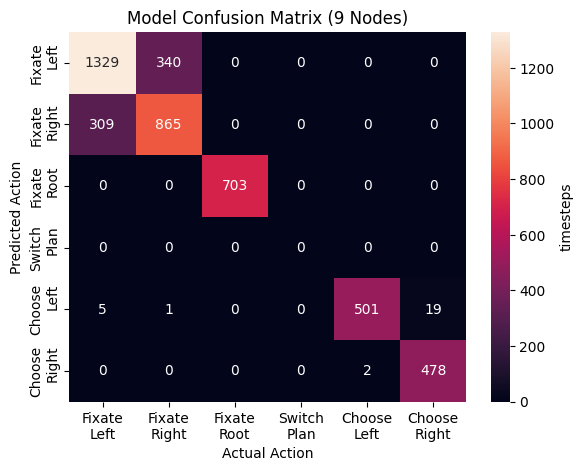

In [10]:
import seaborn as sns 
ts_wrong=[]
confusion_matrix=np.zeros((6,6))
for i in range(1000):
    for j in range(len(test_preds[i])):
        p=test_preds[i][j]
        a=test_actual[i][j]
        if (a in [4,5]) and p!=a:
            ts_wrong.append(len(test_preds[i])) 
        confusion_matrix[p,a]+=1
labels=['Fixate\nLeft','Fixate\nRight','Fixate\nRoot','Switch\nPlan','Choose\nLeft','Choose\nRight']
sns.heatmap(confusion_matrix,annot=True,fmt='g',cbar_kws={'label': 'timesteps'})
plt.title("Model Confusion Matrix (9 Nodes)")
plt.xticks(np.arange(6)+0.5,labels)
plt.yticks(np.arange(6)+0.5,labels)
plt.xlabel("Actual Action")
plt.ylabel("Predicted Action")

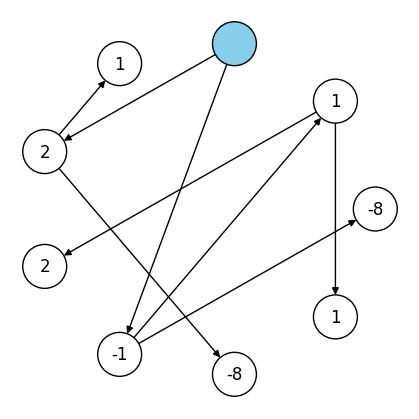

[[ 12.9348955    2.9049122   -7.699228  ]
 [ 12.174956    12.136539    -2.651176  ]
 [ 12.640063    12.626657     3.034747  ]
 [ -0.55887747   2.829776    12.6058655 ]
 [  1.723546    11.849146   -10.017881  ]
 [  8.993108     8.5865     -10.721589  ]
 [ -2.588392    -4.744333     7.0567813 ]]
[ 0. -1.  1.  1.  0.  2. -8.]
['left' 'left' 'left' 'left' 'right' 'right' 'right']
[0. 1. 2. 3. 4. 5. 6.]


In [35]:
from visualization import * 
test_env=DecisionTreeEnv(9)
def re_onehot(o,size=11):
        new_onehot=np.zeros(size)
        new_onehot[:len(o)]=o 
        return new_onehot 

def wrap_observation(obs,num_node=9,set_stage=None):
    inds=[num_node*i for i in range(1,6)]
    for _ in range(3):
        inds.append(inds[-1]+1)
    fixation_onehot,fixation_parent_onehot,fixation_left_child_onehot,fixation_right_child_onehot,root_node_onehot,fixation_reward,timer,stage=np.split(obs,inds)[:-1]
    fixation_onehot=re_onehot(fixation_onehot)
    fixation_parent_onehot=re_onehot(fixation_parent_onehot)
    fixation_left_child_onehot=re_onehot(fixation_left_child_onehot)
    fixation_right_child_onehot=re_onehot(fixation_right_child_onehot)
    root_node_onehot=re_onehot(root_node_onehot)
    if set_stage is not None:
         stage=set_stage 
    return np.hstack([fixation_onehot,fixation_parent_onehot,fixation_left_child_onehot,fixation_right_child_onehot,root_node_onehot,fixation_reward,timer,stage])


def model_fixation_inference(model,env,vis=False):
    obs,_=env.reset()
    if vis:
        visualizer = Visualizer()
        visualizer.plot(env.graph.child_dict, env.graph.rewards)

    done=False 
    hidden=torch.zeros(1,1,6)
    device=torch.device('cpu')
    visited_leafs=0
    fixation_logits=[]
    side='left'

    logits=[]
    logits2=[]
    rewards=[]
    sides=[]
    step=[]

    first=True 

    while done==False:
        
        inds=[env.num_node*i for i in range(1,6)]
        for _ in range(3):
            inds.append(inds[-1]+1)
        fixation_onehot,fixation_parent_onehot,fixation_left_child_onehot,fixation_right_child_onehot,root_node_onehot,fixation_reward,timer,stage=np.split(obs,inds)[:-1]
        fixation_onehot2=re_onehot(fixation_onehot)
        fixation_parent_onehot2=re_onehot(fixation_parent_onehot)
        fixation_left_child_onehot2=re_onehot(fixation_left_child_onehot)
        fixation_right_child_onehot2=re_onehot(fixation_right_child_onehot)
        root_node_onehot2=re_onehot(root_node_onehot)
        next_side=side 
        if np.sum(fixation_left_child_onehot)<1 and np.sum(fixation_right_child_onehot)<1:
             visited_leafs+=1
             if side=='left': 
                next_side='right'

        
        

        env_action_space=[np.argmax(fixation_left_child_onehot),np.argmax(fixation_right_child_onehot),np.argmax(root_node_onehot),env.num_node*2,env.num_node+np.argmax(fixation_left_child_onehot),env.num_node+np.argmax(fixation_right_child_onehot)]


        obs_wrapped_stage0=np.hstack([fixation_onehot2,fixation_parent_onehot2,fixation_left_child_onehot2,fixation_right_child_onehot2,root_node_onehot2,fixation_reward,timer,stage])
        obs_wrapped_stage1=np.hstack([fixation_onehot2,fixation_parent_onehot2,fixation_left_child_onehot2,fixation_right_child_onehot2,root_node_onehot2,fixation_reward,timer,1])
        
        input_tensor=torch.from_numpy(obs_wrapped_stage0.reshape((1,1,-1))).float()
        input_tensor2=torch.from_numpy(obs_wrapped_stage1.reshape((1,1,-1))).float()

        pred2,hidden2=model(input_tensor2,device,hidden=hidden)
        pred,hidden=model(input_tensor,device,hidden=hidden)
        

        original_policy=pred[0,0].detach().numpy()
        perturbed_policy=pred2[0,0].detach().numpy()

        symbolic_action=np.argmax(original_policy[:3])

        policy=original_policy.copy()
        policy[4:]=perturbed_policy[4:]

        logits.append(policy)
        logits2.append(perturbed_policy)
        sides.append(side)
        step.append(timer)

        

        
        env_action=env_action_space[symbolic_action]
        obs, reward, done, _, info=env.step(env_action)
        rewards.append(fixation_reward)
        first=False 
        #print(done,visited_leafs,symbolic_action)
        side=next_side
        if visited_leafs>=2:
            break 
    return np.asarray(logits),np.asarray(rewards)[:,0],np.asarray(sides),np.asarray(step)[:,0]
logits,rewards,sides,step=model_fixation_inference(model,test_env,vis=True)
#logits=np.asarray([softmax(l[4:]) for l in logits])
print(logits[:,:3])
print(rewards)
print(sides)
print(step)




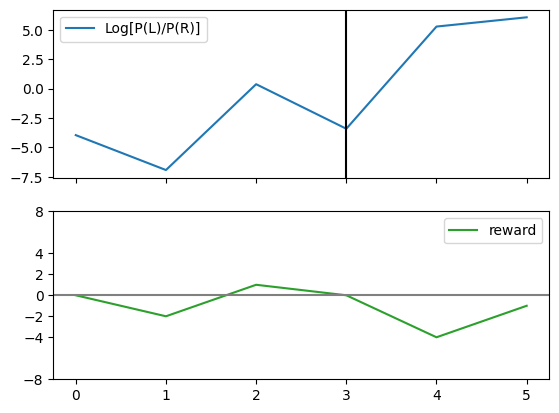

In [23]:
from scipy.special import softmax 

fig,axarr=plt.subplots(nrows=2,sharex=True)
softmaxed=np.asarray([softmax(logits[t,:])for t in range(len(logits))])
axarr[0].plot(np.log(softmaxed[:,4]/softmaxed[:,5]))
axarr[0].legend(['Log[P(L)/P(R)]'])
axarr[1].plot(rewards,color='C2')
axarr[1].legend(['reward'])
axarr[1].set_yticks([-8,-4,-2,0,2,4,8])
axarr[1].axhline(y=0.0,color='grey')
for t in range(len(logits)):
    if rewards[t]==0.0 and t>0:
        axarr[0].axvline(x=t,color='black')

In [150]:
from scipy.special import softmax 
from tqdm import tqdm 
import pandas as pd 
logit=[]
diff_logit=[]
rewards=[]
sides=[]
step=[]
acc_reward=[]
offsets=[]
logit_fix=[]
diff_logit_fix=[]

trial_id=[]
trial=0

graph_dict={}

for _ in tqdm(range(1000)):
    l,r,si,st=model_fixation_inference(model,test_env)
    sm=np.asarray([softmax(l[t][:]) for t in range(len(l))])
    sm2=np.asarray([softmax(l[t][:]) for t in range(len(l))])
    ratio=np.log(sm[:,5]/sm[:,4])
    ratio2=np.log((sm2[:,0]+sm2[:,1])/sm2[:,2])
    ratio_diff=np.diff(ratio)
    ratio_diff2=np.diff(ratio2)

    trial+=1
    offset=-1
    for t in range(len(si)):
        if si[t]=='right':
            offset=t
            break 
    
    for t in range(len(ratio)-1):
        trial_id.append(trial)
        logit.append(ratio[t])
        diff_logit.append(ratio_diff[t])
        diff_logit_fix.append(ratio_diff2[t])
        logit_fix.append(ratio2[t])
        rewards.append(r[t+1])
        acc_reward.append(np.sum(r[:t]))
        sides.append(si[t])
        step.append(st[t])
        offsets.append(st[t]-offset)
df=pd.DataFrame(dict(trial_id=trial_id,logit=logit,logit_fix=logit_fix,delta=diff_logit,delta_fix=diff_logit_fix,reward=rewards,sides=sides,step=step,acc_reward=acc_reward,step2=offsets))
    

100%|██████████| 1000/1000 [00:04<00:00, 248.71it/s]


In [151]:
df[df.step2==0.0]

,trial_id,logit,logit_fix,delta,delta_fix,reward,sides,step,acc_reward,step2
2,1,4.123662,13.906053,-6.407772,0.673576,-2.0,right,2.0,-1.0,0.0
6,2,4.031641,14.413376,8.939562,4.334799,8.0,right,2.0,-1.0,0.0
12,3,-11.877606,21.738533,-0.409332,-34.121944,-2.0,right,4.0,7.0,0.0
17,4,13.182953,21.791176,-0.242605,-25.244022,1.0,right,4.0,-11.0,0.0
21,5,0.797411,20.180813,3.653580,-2.394424,2.0,right,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
5160,996,-12.149874,22.048073,-1.579125,-30.945545,-4.0,right,4.0,8.0,0.0
5163,997,-3.229090,13.409393,-3.300436,1.425589,-2.0,right,2.0,2.0,0.0
5168,998,9.572044,15.413420,-8.217554,-0.573056,-2.0,right,2.0,-4.0,0.0
5173,999,16.390999,19.874660,-6.795397,-30.212574,-8.0,right,3.0,-16.0,0.0


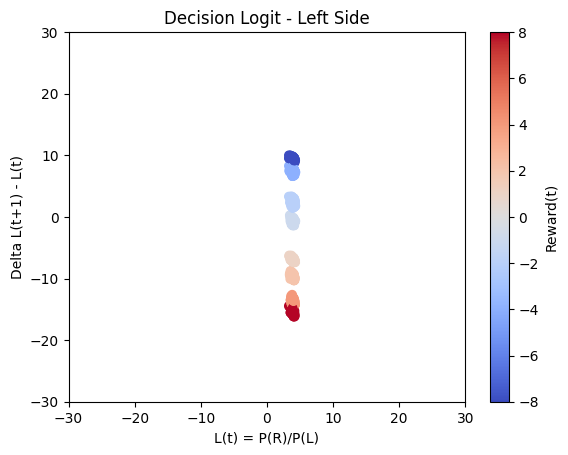

In [158]:

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

sub_df=df[(df['sides']=='left')&(df['step']==0.0)]
plt.scatter(sub_df['logit'],sub_df['delta'],c=sub_df['reward'],cmap='coolwarm')
cbar=plt.colorbar()
cbar.set_label('Reward(t)')
plt.title("Decision Logit - Left Side")
plt.xlabel("L(t) = P(R)/P(L)")
plt.ylabel("Delta L(t+1) - L(t)")
plt.xlim(-30,30)
plt.ylim(-30,30)
plt.savefig('decision_left.pdf',format='pdf')

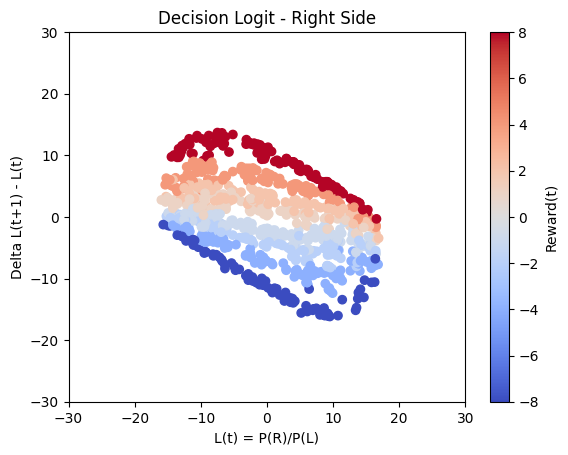

In [153]:

sub_df=df[(df['sides']=='right')&(df['step2']==0.0)]
plt.scatter(sub_df['logit'],sub_df['delta'],c=sub_df['reward'],cmap='coolwarm')
cbar=plt.colorbar()
cbar.set_label('Reward(t)')
plt.title("Decision Logit - Right Side")
plt.xlabel("L(t) = P(R)/P(L)")
plt.ylabel("Delta L(t+1) - L(t)")
plt.xlim(-30,30)
plt.ylim(-30,30)
plt.savefig('decision_right.pdf',format='pdf')

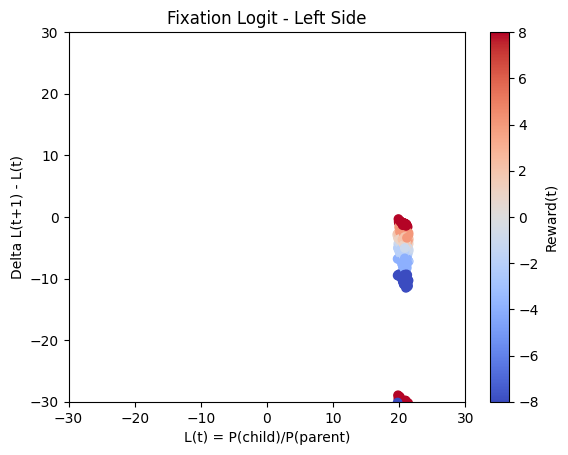

In [156]:

sub_df=df[(df['sides']=='left')&(df['step']==0.0)]
plt.scatter(sub_df['logit_fix'],sub_df['delta_fix'],c=sub_df['reward'],cmap='coolwarm')
cbar=plt.colorbar()
cbar.set_label('Reward(t)')
plt.title("Fixation Logit - Left Side")
plt.xlabel("L(t) = P(child)/P(parent)")
plt.ylabel("Delta L(t+1) - L(t)")
plt.xlim(-30,30)
plt.ylim(-30,30)
plt.savefig('fixation_left.pdf',format='pdf')

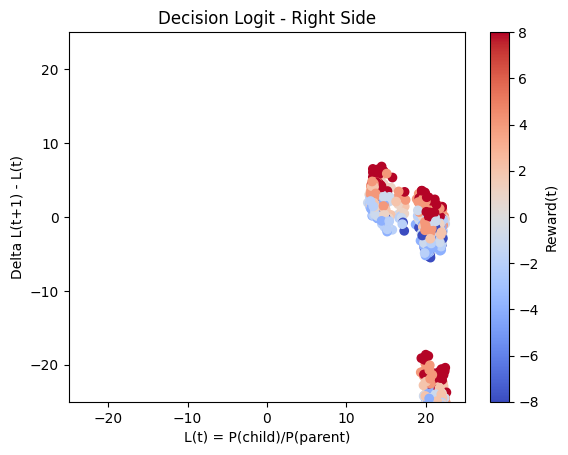

In [155]:

sub_df=df[(df['sides']=='right')&(df['step2']==0.0)]
plt.scatter(sub_df['logit_fix'],sub_df['delta_fix'],c=sub_df['reward'],cmap='coolwarm')
cbar=plt.colorbar()
cbar.set_label('Reward(t)')
plt.title("Decision Logit - Right Side")
plt.xlabel("L(t) = P(child)/P(parent)")
plt.ylabel("Delta L(t+1) - L(t)")
plt.xlim(-25,25)
plt.ylim(-25,25)
plt.savefig('fixation_right.pdf',format='pdf')

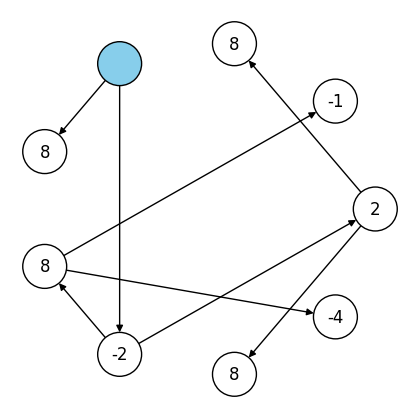

array(['left', 'left', 'left', 'left', 'right', 'right'], dtype='<U5')

In [104]:
l,r,si,st=model_fixation_inference(model,test_env,vis=True)
si

In [94]:
logit=np.asarray(logit)
diff_logit=np.asarray(diff_logit)
reward=np.asarray(rewards)
sides=np.asarray(sides)
step=np.asarray(step)
step2=np.asarray(offsets)
acc_reward=np.asarray(acc_reward)
logit_fix=np.asarray(logit_fix)
delta_fix=np.asarray(diff_logit_fix)
df2=pd.DataFrame(dict(trial_id=np.asarray(trial_id)[:-1],logit=logit[:-1],logit_fix=logit_fix[:-1],delta=diff_logit[:-1],delta_fix=delta_fix[:-1],reward=rewards[1:],sides=sides[:-1],step=step[:-1],acc_reward=acc_reward[1:],step2=step2[:-1]))

In [95]:
df2[(df2.step2==0.0)&(df2.reward==0.0)]

,trial_id,logit,logit_fix,delta,delta_fix,reward,sides,step,acc_reward,step2
31,6,9.003898,20.356384,-9.299815,-26.136644,0.0,right,3.0,0.0,0.0
36,7,-3.613752,21.786737,2.188496,-24.244602,0.0,right,4.0,0.0,0.0
65,12,5.698303,21.797859,-15.206319,-29.580395,0.0,right,4.0,0.0,0.0
85,16,-10.744792,19.429743,-3.763041,-25.491619,0.0,right,3.0,0.0,0.0
97,18,7.268826,21.919985,-12.556633,-29.287533,0.0,right,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
5030,973,1.260261,22.347467,-3.748133,-28.481356,0.0,right,5.0,0.0,0.0
5063,979,-12.306802,21.488525,7.765805,-30.107056,0.0,right,4.0,0.0,0.0
5087,984,13.289015,20.786175,-8.544786,-26.750923,0.0,right,3.0,0.0,0.0
5141,994,16.430824,21.186634,-5.460741,-30.268272,0.0,right,4.0,0.0,0.0


In [97]:
df2[25:34]

,trial_id,logit,logit_fix,delta,delta_fix,reward,sides,step,acc_reward,step2
25,5,9.528296,20.456587,-9.852691,-4.110506,-4.0,right,3.0,-5.0,0.0
26,5,-0.324395,16.346081,-8.705948,3.007591,-8.0,right,4.0,-9.0,1.0
27,5,-9.030343,19.353672,9.404963,-19.104832,0.0,right,5.0,0.0,2.0
28,6,3.456334,19.910229,9.792181,-9.294606,-8.0,left,0.0,0.0,-3.0
29,6,13.248514,10.615623,-7.113304,-21.697403,2.0,left,1.0,-8.0,-2.0
30,6,6.135210,-11.081780,2.868688,31.438164,0.0,left,2.0,-6.0,-1.0
31,6,9.003898,20.356384,-9.299815,-26.136644,0.0,right,3.0,0.0,0.0
32,7,4.184234,20.706257,-0.578725,-5.206037,-1.0,left,0.0,0.0,-4.0
33,7,3.605509,15.500220,7.442873,-9.098161,-4.0,left,1.0,-1.0,-3.0


In [99]:
df2[df2.trial_id==5]

,trial_id,logit,logit_fix,delta,delta_fix,reward,sides,step,acc_reward,step2
22,5,3.950449,20.811861,-0.528117,-5.204653,-1.0,left,0.0,0.0,-3.0
23,5,3.422332,15.607208,7.315281,-27.993034,-4.0,left,1.0,-1.0,-2.0
24,5,10.737613,-12.385827,-1.209317,32.842415,0.0,left,2.0,-5.0,-1.0
25,5,9.528296,20.456587,-9.852691,-4.110506,-4.0,right,3.0,-5.0,0.0
26,5,-0.324395,16.346081,-8.705948,3.007591,-8.0,right,4.0,-9.0,1.0
27,5,-9.030343,19.353672,9.404963,-19.104832,0.0,right,5.0,0.0,2.0


In [100]:
df2[df2.trial_id==6]

,trial_id,logit,logit_fix,delta,delta_fix,reward,sides,step,acc_reward,step2
28,6,3.456334,19.910229,9.792181,-9.294606,-8.0,left,0.0,0.0,-3.0
29,6,13.248514,10.615623,-7.113304,-21.697403,2.0,left,1.0,-8.0,-2.0
30,6,6.135210,-11.081780,2.868688,31.438164,0.0,left,2.0,-6.0,-1.0
31,6,9.003898,20.356384,-9.299815,-26.136644,0.0,right,3.0,0.0,0.0


(-25.0, 25.0)

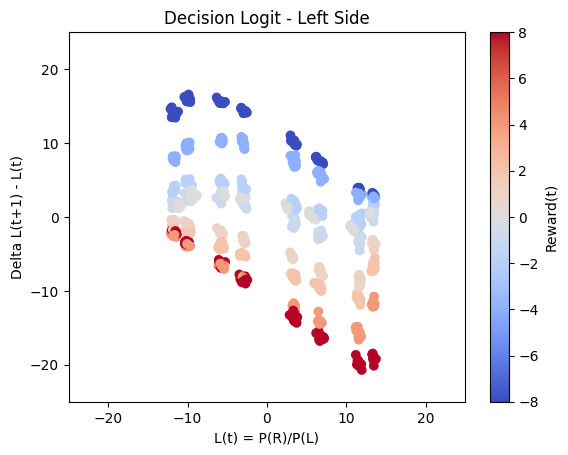

In [80]:

sub_df=df2[(df2['sides']=='left')&(df2['step']==1.0)]
plt.scatter(sub_df['logit'],sub_df['delta'],c=sub_df['reward'],cmap='coolwarm')
cbar=plt.colorbar()
cbar.set_label('Reward(t)')
plt.title("Decision Logit - Left Side")
plt.xlabel("L(t) = P(R)/P(L)")
plt.ylabel("Delta L(t+1) - L(t)")
plt.xlim(-25,25)
plt.ylim(-25,25)

In [105]:

sub_df=df2[((df2['step2']==1.0)]
plt.scatter(sub_df['logit'],sub_df['delta'],c=sub_df['reward'],cmap='coolwarm')
cbar=plt.colorbar()
cbar.set_label('Reward(t)')
plt.title("Decision Logit - Right Side")
plt.xlabel("L(t) = P(R)/P(L) time t")
plt.ylabel("Delta L(t+1) - L(t)")
plt.xlim(-25,25)
plt.ylim(-25,25)

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (3034176414.py, line 1)

(-25.0, 25.0)

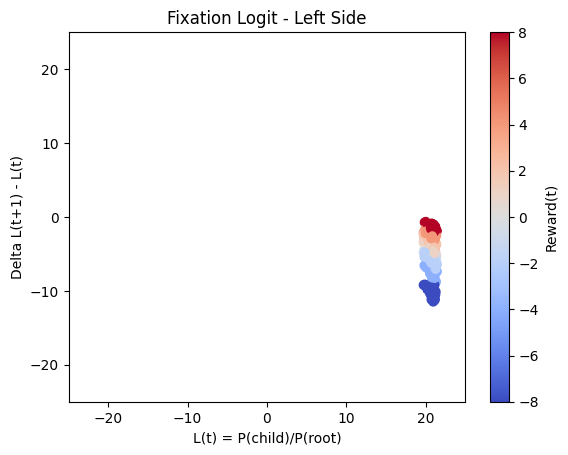

In [107]:

sub_df=df2[(df2['sides']=='left')&(df2['step']==0.0)]
plt.scatter(sub_df['logit_fix'],sub_df['delta_fix'],c=sub_df['reward'],cmap='coolwarm')
cbar=plt.colorbar()
cbar.set_label('Reward(t)')
plt.title("Fixation Logit - Left Side")
plt.xlabel("L(t) = P(child)/P(root)")
plt.ylabel("Delta L(t+1) - L(t)")
plt.xlim(-25,25)
plt.ylim(-25,25)

Text(0, 0.5, 'Delta L(t+1) - L(t)')

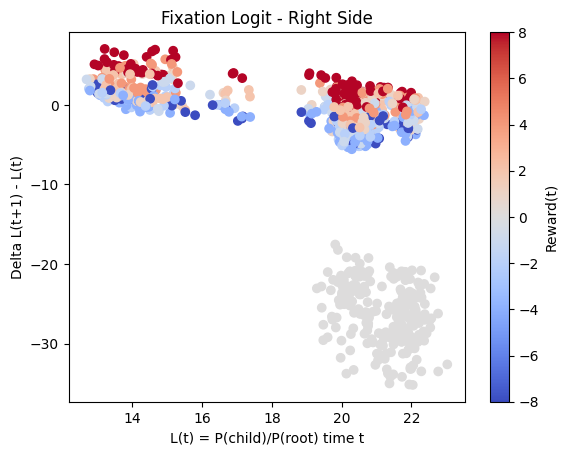

In [108]:

sub_df=df2[(df2['sides']=='right')&(df2['step2']==0.0)]
plt.scatter(sub_df['logit_fix'],sub_df['delta_fix'],c=sub_df['reward'],cmap='coolwarm')
cbar=plt.colorbar()
cbar.set_label('Reward(t)')
plt.title("Fixation Logit - Right Side")
plt.xlabel("L(t) = P(child)/P(root) time t")
plt.ylabel("Delta L(t+1) - L(t)")


(-25.0, 25.0)

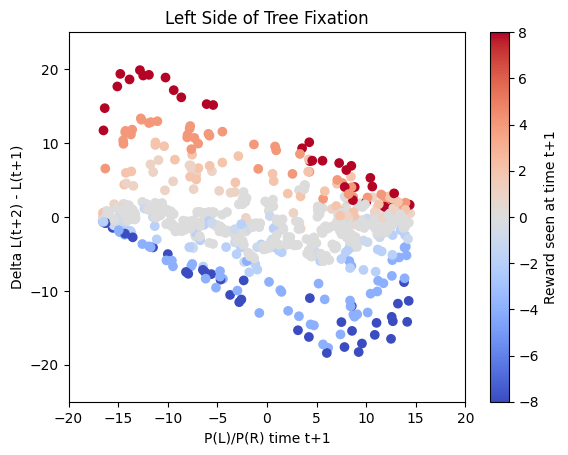

In [20]:

sub_df=df2[(df2['sides']=='left')&(df2['step']==2.0)]
plt.scatter(sub_df['logit'],sub_df['delta'],c=sub_df['reward'],cmap='coolwarm')
cbar=plt.colorbar()
cbar.set_label('Reward seen at time t+1')
plt.title("Left Side of Tree Fixation")
plt.xlabel("P(L)/P(R) time t+1")
plt.ylabel("Delta L(t+2) - L(t+1)")
plt.xlim(-20,20)
plt.ylim(-25,25)

Text(0, 0.5, 'Delta L(t+2) - L(t+1)')

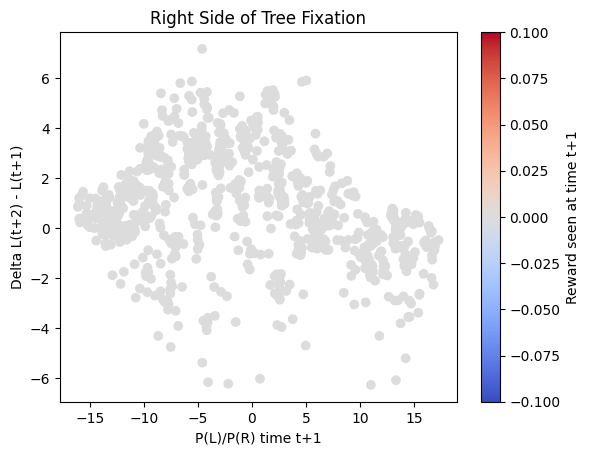

In [111]:

sub_df=df2[(df2['sides']=='left')&(df2['step2']==-1.0)]
plt.scatter(sub_df['logit'],sub_df['delta'],c=sub_df['reward'],cmap='coolwarm')
cbar=plt.colorbar()
cbar.set_label('Reward seen at time t+1')
plt.title("Right Side of Tree Fixation")
plt.xlabel("P(L)/P(R) time t+1")
plt.ylabel("Delta L(t+2) - L(t+1)")


In [47]:
from scipy.special import softmax 
from tqdm import tqdm 
import pandas as pd 
logit=[]
diff_logit=[]
rewards=[]
sides=[]
step=[]
acc_reward=[]
offsets=[]
for _ in tqdm(range(1000)):
    l,r,si,st=model_fixation_inference(model,test_env)
    sm=np.asarray([softmax(l[t][4:]) for t in range(len(l))])
    ratio=np.log(sm[:,0]/sm[:,1])
    offset=-1
    for t in range(len(si)):
        if si[t]=='right':
            offset=t
            break 
    for t in range(len(ratio)-2):
        logit.append(ratio[t])
        diff_logit.append(ratio[t+2]-ratio[t])
        rewards.append(r[t+1]+r[t+2])
        acc_reward.append(np.sum(r[:t]))
        sides.append(si[t])
        step.append(st[t])
        offsets.append(st[t]-offset)

df=pd.DataFrame(dict(logit=logit,delta=diff_logit,reward=rewards,sides=sides,step=step,acc_reward=acc_reward,step2=offsets))
    

100%|██████████| 1000/1000 [00:04<00:00, 246.18it/s]


In [48]:
df

,logit,delta,reward,sides,step,acc_reward,step2
0,-4.079743,-5.466192,-4.0,left,0.0,0.0,-2.0
1,-10.990501,13.354086,-4.0,left,1.0,0.0,-1.0
2,-9.545935,4.854594,0.0,right,2.0,-4.0,0.0
3,2.363585,-0.761280,0.0,right,3.0,-4.0,1.0
4,-4.159212,-2.586222,-3.0,left,0.0,0.0,-3.0
...,...,...,...,...,...,...,...
4203,-3.996310,11.256111,4.0,left,0.0,0.0,-2.0
4204,9.593448,-3.821733,1.0,left,1.0,0.0,-1.0
4205,7.259802,0.599765,0.0,right,2.0,4.0,0.0
4206,5.771714,5.296474,-5.0,right,3.0,4.0,1.0


(-25.0, 25.0)

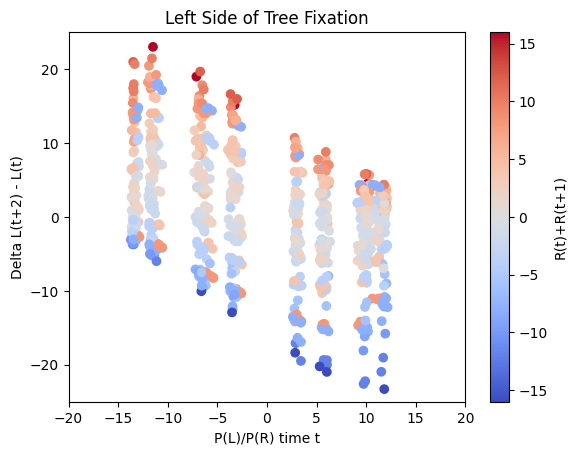

In [49]:

sub_df=df[(df['sides']=='left')&(df['step']==1)]
plt.scatter(sub_df['logit'],sub_df['delta'],c=sub_df['reward'],cmap='coolwarm')
cbar=plt.colorbar()
cbar.set_label('R(t)+R(t+1)')
plt.title("Left Side of Tree Fixation")
plt.xlabel("P(L)/P(R) time t")
plt.ylabel("Delta L(t+2) - L(t)")
plt.xlim(-20,20)
plt.ylim(-25,25)


(-25.0, 25.0)

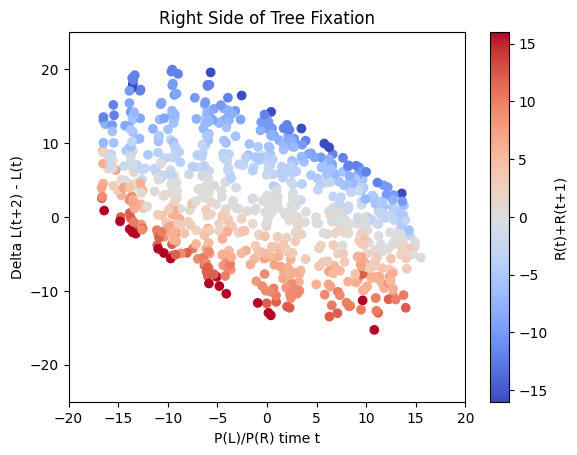

In [53]:

sub_df=df[(df['sides']=='right')&(df['step2']==0)]
plt.scatter(sub_df['logit'],sub_df['delta'],c=sub_df['reward'],cmap='coolwarm')
cbar=plt.colorbar()
cbar.set_label('R(t)+R(t+1)')
plt.title("Right Side of Tree Fixation")
plt.xlabel("P(L)/P(R) time t")
plt.ylabel("Delta L(t+2) - L(t)")
plt.xlim(-20,20)
plt.ylim(-25,25)
